## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_M")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,65.149895,0,30.0,0.460200,83.371297,0.508610,89.066304,10.318461,272.893918,...,245.139997,0.385395,209.332939,41.129640,592.191757,3.234648,18110.527190,6.948,2826.0,6861.9
1,1,67.206024,0,30.0,0.329647,149.712265,0.328176,109.824210,13.761403,289.584573,...,221.932844,0.406722,197.689209,42.149774,568.823992,3.240436,23801.869010,7.090,3792.0,7378.1
2,0,58.773440,0,30.0,0.385797,104.769354,0.545986,125.678783,15.521177,397.945779,...,283.711655,0.336695,217.002950,41.289080,584.300146,3.069283,17579.374770,6.832,2964.0,7983.5
3,0,55.096508,0,30.0,0.229011,166.953431,0.275601,112.186834,18.126786,281.793906,...,231.188679,0.498026,232.827358,33.062621,700.120751,3.093719,4888.606116,6.523,3184.0,8525.1
4,0,48.030117,0,29.0,0.242913,86.816221,0.377439,73.484651,13.463920,207.122381,...,245.120671,0.458936,233.016858,44.574015,686.946759,3.149858,22134.931110,8.253,3419.0,9320.5


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((889, 22), (381, 22))

In [4]:
imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_knn = imputer_nonLin.transform(X_train)
X_test_knn = imputer_nonLin.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((889, 22), (381, 22))

In [8]:
sel = ['Gender', 'MMSE', 'Hip Correlation', 'Hip Variance ',
       'Hip Sum Variance', 'Hip Entropy', 'ERC ASM', 'ERC VARIANCE ',
       'ERC ENTROPY', 'ERC CLUSTER SHADE', 'ERCs_thicknessbaseline',
       'ERCsVolumebaseline', 'TOTAL_HIPPOCAMPUS_VOLUME']

In [9]:
# Store selected feature names before transformation
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['Gender',
 'MMSE',
 'Hip Correlation',
 'Hip Variance ',
 'Hip Sum Variance',
 'Hip Entropy',
 'ERC ASM',
 'ERC VARIANCE ',
 'ERC ENTROPY',
 'ERC CLUSTER SHADE',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'TOTAL_HIPPOCAMPUS_VOLUME']

In [10]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((889, 13), (381, 13))

## TPE

In [11]:
def objective(trial):
    
    
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 500)
    rf_criterion = trial.suggest_categorical("rf_criterion", ['gini', 'entropy'])
    rf_max_depth = trial.suggest_int("rf_max_depth", 3, 4)
    rf_min_samples_split = trial.suggest_float("rf_min_samples_split", 0.001, 0.2)
    rf_max_features = trial.suggest_categorical("rf_max_features", ["sqrt", "log2"])
    rf_min_samples_leaf = trial.suggest_float("rf_min_samples_leaf", 0.001, 0.1)
    rf_class_weight = trial.suggest_categorical("rf_class_weight", ["balanced", "balanced_subsample"])
        
    model = RandomForestClassifier(n_estimators=rf_n_estimators, 
                                   criterion=rf_criterion,
                                   max_depth=rf_max_depth,
                                   min_samples_split=rf_min_samples_split,
                                   max_features=rf_max_features,
                                   min_samples_leaf=rf_min_samples_leaf,
                                   random_state=42, 
                                   class_weight=rf_class_weight)

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [12]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-07-27 17:27:46,609] A new study created in memory with name: no-name-27caeff8-21a4-4821-8152-2e0888d85552


[I 2025-07-27 17:27:52,971] Trial 0 finished with value: 0.658157178660938 and parameters: {'rf_n_estimators': 147, 'rf_criterion': 'gini', 'rf_max_depth': 4, 'rf_min_samples_split': 0.14967172262905307, 'rf_max_features': 'sqrt', 'rf_min_samples_leaf': 0.0878192921703115, 'rf_class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.658157178660938.
[I 2025-07-27 17:28:11,001] Trial 1 finished with value: 0.6728453276047262 and parameters: {'rf_n_estimators': 419, 'rf_criterion': 'entropy', 'rf_max_depth': 4, 'rf_min_samples_split': 0.15630475194654284, 'rf_max_features': 'sqrt', 'rf_min_samples_leaf': 0.06389029109077721, 'rf_class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.6728453276047262.
[I 2025-07-27 17:28:18,968] Trial 2 finished with value: 0.6774514858575009 and parameters: {'rf_n_estimators': 216, 'rf_criterion': 'gini', 'rf_max_depth': 3, 'rf_min_samples_split': 0.09944467431413302, 'rf_max_features': 'sqrt', 'rf_min_samples_leaf': 0.05560540704

In [13]:
study.best_params

{'rf_n_estimators': 235,
 'rf_criterion': 'entropy',
 'rf_max_depth': 4,
 'rf_min_samples_split': 0.08311015332205791,
 'rf_max_features': 'sqrt',
 'rf_min_samples_leaf': 0.02241493821901569,
 'rf_class_weight': 'balanced_subsample'}

In [14]:
study.best_value

0.6840440386680988

In [15]:
r = study.trials_dataframe()
r.head()

,number,value,datetime_start,datetime_complete,duration,params_rf_class_weight,params_rf_criterion,params_rf_max_depth,params_rf_max_features,params_rf_min_samples_leaf,params_rf_min_samples_split,params_rf_n_estimators,state
0,0,0.658157,2025-07-27 17:27:46.609564,2025-07-27 17:27:52.971746,0 days 00:00:06.362182,balanced_subsample,gini,4,sqrt,0.087819,0.149672,147,COMPLETE
1,1,0.672845,2025-07-27 17:27:52.971746,2025-07-27 17:28:11.001293,0 days 00:00:18.029547,balanced_subsample,entropy,4,sqrt,0.063890,0.156305,419,COMPLETE
2,2,0.677451,2025-07-27 17:28:11.001293,2025-07-27 17:28:18.968400,0 days 00:00:07.967107,balanced_subsample,gini,3,sqrt,0.055605,0.099445,216,COMPLETE
3,3,0.678781,2025-07-27 17:28:18.968400,2025-07-27 17:28:29.119049,0 days 00:00:10.150649,balanced_subsample,entropy,3,sqrt,0.028056,0.035482,234,COMPLETE
4,4,0.674670,2025-07-27 17:28:29.119049,2025-07-27 17:28:37.103193,0 days 00:00:07.984144,balanced_subsample,gini,4,log2,0.051432,0.029710,171,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_11120\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


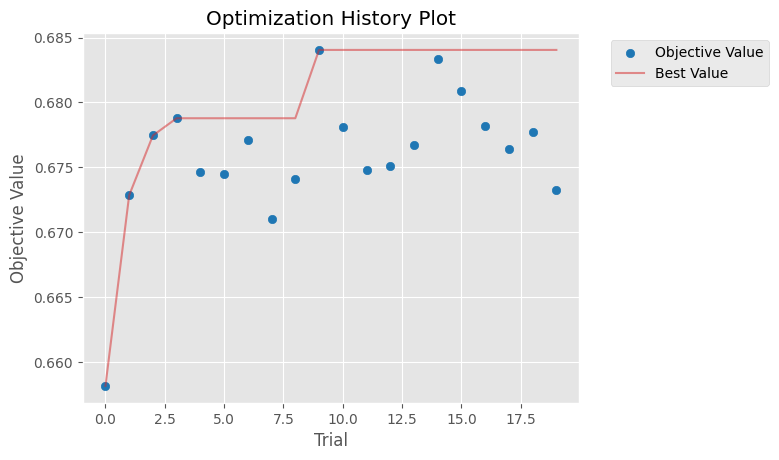

In [16]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_11120\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

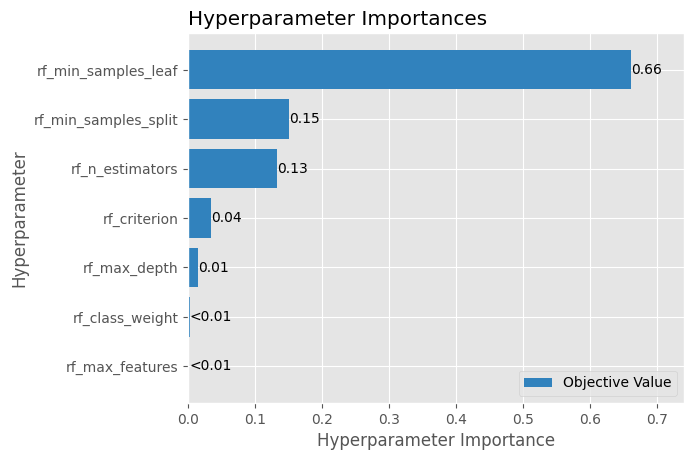

In [17]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_11120\3879122787.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='rf_class_weight', ylabel='Objective Value'>,
       <Axes: xlabel='rf_criterion'>, <Axes: xlabel='rf_max_depth'>,
       <Axes: xlabel='rf_max_features'>,
       <Axes: xlabel='rf_min_samples_leaf'>,
       <Axes: xlabel='rf_min_samples_split'>,
       <Axes: xlabel='rf_n_estimators'>], dtype=object)

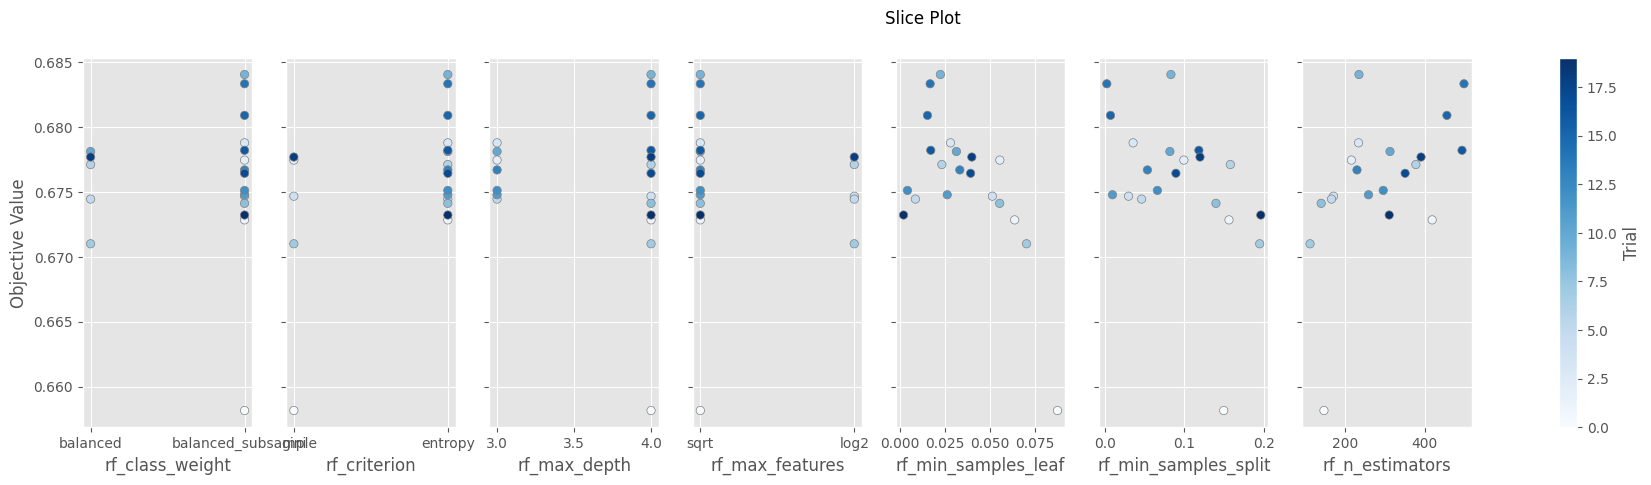

In [18]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["rf_n_estimators", "rf_criterion", "rf_max_depth", 
            'rf_min_samples_split', 'rf_max_features', 'rf_min_samples_leaf',
            'rf_class_weight'],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_11120\2601326980.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

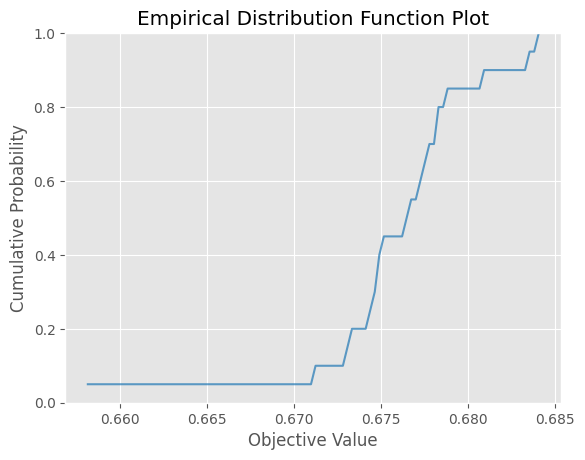

In [19]:
optuna.visualization.matplotlib.plot_edf([study])

## Classification

In [20]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        model = RandomForestClassifier(n_estimators=study.best_params["rf_n_estimators"], 
                                       criterion=study.best_params["rf_criterion"],
                                       max_depth=study.best_params["rf_max_depth"],
                                       min_samples_split=study.best_params["rf_min_samples_split"],
                                       max_features=study.best_params["rf_max_features"],
                                       min_samples_leaf=study.best_params["rf_min_samples_leaf"],
                                       random_state=42, 
                                       class_weight=study.best_params["rf_class_weight"])
        
        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [21]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", "Complete", X_train_knn_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", "Boruta", X_train_t, y_train)

In [22]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [23]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [24]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)        
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=1000,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [25]:
results = "all"
prediction_df_report = None

if results == "all":
    
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
  
    prediction_df = pd.concat([pred_rf_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier    Classification Time Total Features Metric                          
Boruta            Random Forest 0.265               22             accuracy                0.730   
                                                                   balanced_accuracy       0.723   
                                                                   precision_macro         0.698   
                                                                   recall_macro            0.723   
                                                                   f1_macro                0.705   
                                                                   roc_auc_macro           0.902   
                                                                   specificity_macro       0.866   
                                0.412               13             accuracy                0.721   
                                                                   balanced_accuracy       0.723   
                                                                   precision_macro         0.697   
                                                                   recall_macro            0.723   
                                                                   f1_macro                0.702   
                                                                   roc_auc_macro           0.899   
                                                                   specificity_macro       0.862   

                                                                                      Test data  \
Feature Selection Classifier    Classification Time Total Features Metric                         
Boruta            Random Forest 0.265               22             accuracy               0.732   
                                                                   balanced_accuracy      0.733   
                                                                   precision_macro        0.706   
                                                                   recall_macro           0.733   
                                                                   f1_macro               0.702   
                                                                   roc_auc_macro          0.885   
                                                                   specificity_macro      0.863   
                                0.412               13             accuracy               0.722   
                                                                   balanced_accuracy      0.724   
                                                                   precision_macro        0.696   
                                                                   recall_macro           0.724   
                                                                   f1_macro               0.693   
                                                                   roc_auc_macro          0.881   
                                                                   specificity_macro      0.859   

                                                                                              95% CI  \
Feature Selection Classifier    Classification Time Total Features Metric                              
Boruta            Random Forest 0.265               22             accuracy           [0.685, 0.772]   
                                                                   balanced_accuracy  [0.679, 0.782]   
                                                                   precision_macro    [0.668, 0.748]   
                                                                   recall_macro       [0.681, 0.783]   
                                                                   f1_macro           [0.654, 0.748]   
                                                                   roc_auc_macro      [0.855, 0.912]   
                                                                   s

### Export model

In [26]:
trained_rf_t

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, min_samples_leaf=0.02241493821901569,
                       min_samples_split=0.08311015332205791, n_estimators=235,
                       random_state=42)

In [27]:
import pickle

with open("rf_model.pkl", "wb") as file:
    pickle.dump(trained_rf_t, file)
    
print("Random Forest model saved successfully!")

Random Forest model saved successfully!
